In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

game = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/review_game.csv')
game


,Unnamed: 0,name,content,reconmended,posted
0,1,Cheating Death,\r\nResident Evil that we deserve.\r\nCapcom. ...,Recommended,"29 January, 2019"
1,2,Kibblekaze,\r\nI am finally home again. Raccoon City. Now...,Recommended,"24 January, 2019"
2,3,AUD,\r\nProbably the best remake game I've ever pl...,Recommended,"26 January, 2019"
3,4,⛧ M†ropele ⛧,\r\nWhat a way to start off 2019 dude. My god....,Recommended,"24 January, 2019"
4,5,Chase,\r\nMy only regret playing this is now I want ...,Recommended,"11 November, 2019"
...,...,...,...,...,...
1765,1766,ʙ⌁¹¹⁰¹,\r\nbullet sponge zombie went down for the thi...,Not Recommended,"January 27, 2019"
1766,1767,vermilion,"\r\nAn excellent game, a great remaking. You s...",Not Recommended,"February 2, 2019"
1767,1768,madvillain,\r\nThis game is like fun but it's story sucks...,Not Recommended,"January 28, 2019"
1768,1769,Titillating Bwefass,\r\nVery disappointed in this initally. The ga...,Not Recommended,"January 28, 2019"


In [3]:
import re
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                           text)
    text = (re.sub('[\W]+', ' ', text.lower()) +
            ' '.join(emoticons).replace('-', ''))
    return text


game['content'] = game['content'].apply(preprocessor)
game

,Unnamed: 0,name,content,reconmended,posted
0,1,Cheating Death,resident evil that we deserve capcom i have o...,Recommended,"29 January, 2019"
1,2,Kibblekaze,i am finally home again raccoon city now they...,Recommended,"24 January, 2019"
2,3,AUD,probably the best remake game i ve ever played,Recommended,"26 January, 2019"
3,4,⛧ M†ropele ⛧,what a way to start off 2019 dude my god gorg...,Recommended,"24 January, 2019"
4,5,Chase,my only regret playing this is now i want res...,Recommended,"11 November, 2019"
...,...,...,...,...,...
1765,1766,ʙ⌁¹¹⁰¹,bullet sponge zombie went down for the third ...,Not Recommended,"January 27, 2019"
1766,1767,vermilion,an excellent game a great remaking you shall ...,Not Recommended,"February 2, 2019"
1767,1768,madvillain,this game is like fun but it s story sucks an...,Not Recommended,"January 28, 2019"
1768,1769,Titillating Bwefass,very disappointed in this initally the game l...,Not Recommended,"January 28, 2019"


In [4]:
from nltk.stem.porter import PorterStemmer

porter = PorterStemmer()

def tokenizer(text):
    return text.split()


def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stop = stopwords.words('english')

X = game.iloc[:, 2].values
y = game.iloc[:,3].values


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                    random_state = 0)
unique, counts = np.unique(y, return_counts=True)
print(dict(zip(unique, counts)))
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))
unique, counts = np.unique(y_test, return_counts=True)
print(dict(zip(unique, counts)))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
{'Not Recommended': 724, 'Recommended': 1046}
{'Not Recommended': 584, 'Recommended': 832}
{'Not Recommended': 140, 'Recommended': 214}


In [5]:


from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

param_grid = [{'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 10.0, 100.0]},
              {'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter],
               'vect__use_idf':[False],
               'vect__norm':[None],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 10.0, 100.0]},
              ]

lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', LogisticRegression(random_state=0))])

gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=1,
                           n_jobs=-1)


gs_lr_tfidf.fit(X_train, y_train)
print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)
print('CV Accuracy: %.3f' % gs_lr_tfidf.best_score_)

lr = gs_lr_tfidf.best_estimator_
from sklearn.metrics import classification_report
print(classification_report(y_test, lr.predict(X_test)))

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   58.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  5.4min finished


Best parameter set: {'clf__C': 100.0, 'clf__penalty': 'l2', 'vect__ngram_range': (1, 1), 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer at 0x7fabc356d8c8>} 
CV Accuracy: 0.880
                 precision    recall  f1-score   support

Not Recommended       0.85      0.76      0.80       140
    Recommended       0.85      0.91      0.88       214

       accuracy                           0.85       354
      macro avg       0.85      0.83      0.84       354
   weighted avg       0.85      0.85      0.85       354



In [6]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

param_grid = [{'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter],
               'svc__kernel': ['liblinear', 'rbf', 'poly'],
               'svc__C': [0.1, 1.0, 10.0, 100.0],
               'svc__gamma': [0.0001, 0.001, 0.01, 0.1, 1.0]},
              {'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter],
               'vect__use_idf':[False],
               'vect__norm':[None],
               'svc__kernel': ['liblinear', 'rbf', 'poly'],
               'svc__C': [0.1, 1.0, 10.0, 100.0],
               'svc__gamma': [0.0001, 0.001, 0.01, 0.1, 1.0]},
              ]

svc_tfidf = Pipeline([('vect', tfidf),
                     ('svc', SVC(random_state=0))])

gs_svc_tfidf = GridSearchCV(svc_tfidf, param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=1,
                           n_jobs=-1)


gs_svc_tfidf.fit(X_train, y_train)



Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 450 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 800 tasks      | elapsed: 22.1min
[Parallel(n_jobs=-1)]: Done 1250 tasks      | elapsed: 34.8min
[Parallel(n_jobs=-1)]: Done 1800 tasks      | elapsed: 49.9min
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed: 66.5min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=False,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        n

In [7]:
print('Best parameter set: %s ' % gs_svc_tfidf.best_params_)
print('CV Accuracy: %.3f' % gs_svc_tfidf.best_score_)

svc = gs_svc_tfidf.best_estimator_
from sklearn.metrics import classification_report
print(classification_report(y_test, svc.predict(X_test)))

Best parameter set: {'svc__C': 10.0, 'svc__gamma': 1.0, 'svc__kernel': 'rbf', 'vect__ngram_range': (1, 1), 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer_porter at 0x7fabc356dae8>} 
CV Accuracy: 0.880
                 precision    recall  f1-score   support

Not Recommended       0.85      0.81      0.83       140
    Recommended       0.88      0.91      0.89       214

       accuracy                           0.87       354
      macro avg       0.87      0.86      0.86       354
   weighted avg       0.87      0.87      0.87       354



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


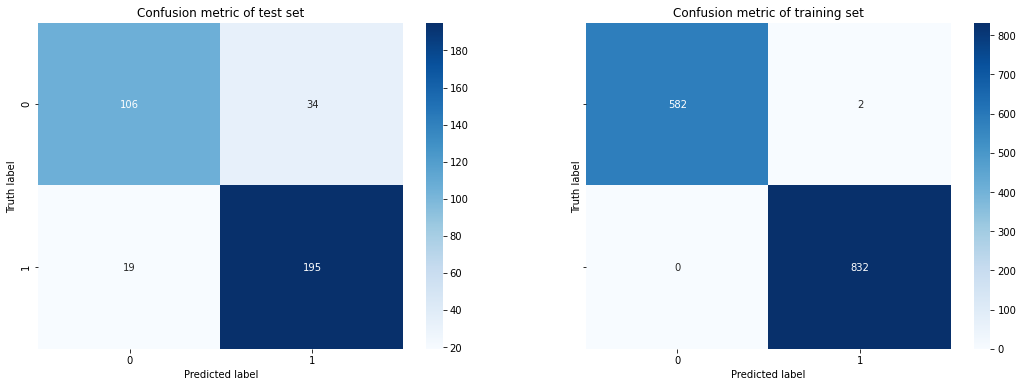

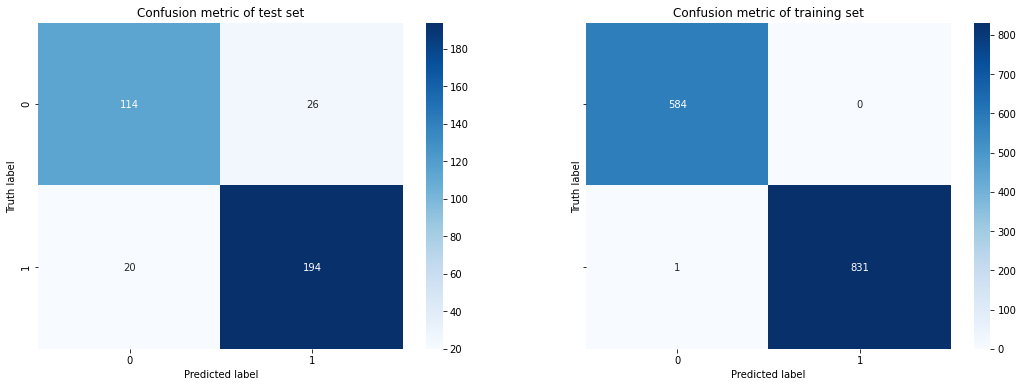

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cm_lr_test = confusion_matrix(y_test, lr.predict(X_test))
cm_svc_test = confusion_matrix(y_test, svc.predict(X_test))
cm_lr_train = confusion_matrix(y_train, lr.predict(X_train))
cm_svc_train = confusion_matrix(y_train, svc.predict(X_train))

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (18, 6), sharey=True)
g1 = sns.heatmap(cm_lr_test, annot = True, cmap = 'Blues', fmt = 'd', ax = ax1)
g1.set_xlabel('Predicted label')
g1.set_ylabel('Truth label')
g1.set_title('Confusion metric of test set')

g2 = sns.heatmap(cm_lr_train, annot = True, cmap = 'Blues', fmt = 'd', ax = ax2)
g2.set_xlabel('Predicted label')
g2.set_ylabel('Truth label')
g2.set_title('Confusion metric of training set')
plt.savefig('/content/drive/My Drive/Colab Notebooks/images/game_06.png', dpi=300)
plt.show()

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (18, 6), sharey=True)
g1 = sns.heatmap(cm_svc_test, annot = True, cmap = 'Blues', fmt = 'd', ax = ax1)
g1.set_xlabel('Predicted label')
g1.set_ylabel('Truth label')
g1.set_title('Confusion metric of test set')

g2 = sns.heatmap(cm_svc_train, annot = True, cmap = 'Blues', fmt = 'd', ax = ax2)
g2.set_xlabel('Predicted label')
g2.set_ylabel('Truth label')
g2.set_title('Confusion metric of training set')
plt.savefig('/content/drive/My Drive/Colab Notebooks/images/game_07.png', dpi=300)
plt.show()

In [ ]:
y_test

array(['Recommended', 'Recommended', 'Recommended', 'Recommended',
       'Recommended', 'Recommended', 'Recommended', 'Recommended',
       'Not Recommended', 'Recommended', 'Not Recommended',
       'Not Recommended', 'Not Recommended', 'Not Recommended',
       'Recommended', 'Not Recommended', 'Recommended', 'Recommended',
       'Recommended', 'Not Recommended', 'Recommended', 'Not Recommended',
       'Recommended', 'Recommended', 'Not Recommended', 'Recommended',
       'Recommended', 'Recommended', 'Recommended', 'Recommended',
       'Not Recommended', 'Recommended', 'Recommended', 'Recommended',
       'Recommended', 'Recommended', 'Not Recommended', 'Not Recommended',
       'Recommended', 'Not Recommended', 'Not Recommended',
       'Not Recommended', 'Not Recommended', 'Not Recommended',
       'Recommended', 'Recommended', 'Recommended', 'Recommended',
       'Recommended', 'Recommended', 'Recommended', 'Not Recommended',
       'Not Recommended', 'Not Recommended', 'Reco

In [14]:
print(svc.predict(['Good']))
print(svc.predict(['you should not play this game']))
print(svc.predict(['the fuck game']))
print(lr.predict(['I hate game']))

['Recommended']
['Not Recommended']
['Not Recommended']
['Not Recommended']
